In [1]:
import os
import sys
from IPython.display import display, clear_output
import tensorflow as tf

sys.path.append(os.path.abspath("../"))
from src.utils import reload_script
from models_src.Support import LRCallback

from matplotlib import pyplot as plt
%matplotlib inline

clear_output(wait=True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1733226758.122205  125131 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733226758.133442  125131 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733226758.133525  125131 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# set up databases
config_path = "../exp_lib/general_config/radial_enc_vec_det.json"
%run -i ../exp_lib/datasets_generators/radial_enc_vec_det.py {config_path}
clear_output(wait=True)

I0000 00:00:1733226761.191570  125131 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733226761.191711  125131 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733226761.191740  125131 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733226761.656802  125131 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733226761.657028  125131 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-03

In [3]:
# set up mlflow instance
%run -i ../exp_lib/mlflow/local_experiment.py {cfg.experiment_name}

In [6]:
# set up Trainer
#model_def_path = "../exp_lib/model_def/radial_enc_vec_det/unet_backbone.json"
model_def_path = "../exp_lib/model_def/radial_enc_vec_det/radial_backbone.json"
trainer = None
%run -i ../exp_lib/utils/trainer_loader.py {model_def_path}

GridBox(children=(Text(value='fun-cat-453', description='run_name', layout=Layout(height='30px', width='300px'…

Button(description='Pass Parameters', style=ButtonStyle())

GridBox(children=(Text(value='frequency', description='enc_type', layout=Layout(height='30px', width='300px'),…

Button(description='Accept Parameters', style=ButtonStyle())

Dictionary updated: {'enc_type': 'frequency', 'num_heads': 2, 'embs_dim': 128, 'color_embs_dim': 16, 'size': 32, 'embs_mid_layers': 2, 'dropout': 0.0, 'activation': 'relu', 'out_mid_layers': 2, 'attns_num': 3, 'pos_enc_matmul': False, 'queries_self_attn': True, 'queries_pos_enc_values': True, 'source_query_cross_attn': False, 'sample_queries_num': None, 'angle_based_preds': False, 'backbone_def': {'run_name': 'fun-cat-453', 'load_mlflow_weights': True, 'load_mode': 'mlflow'}, 'backbone_trainable': False, 'backbone_last_layer': 'PostFFN-AddNorm_3', 'backbone_init_layer': 'Batch-Normalization', 'features_update': False, 'thickness_pred': True, 'sample_points': 20}


Colors only mode ON. Any backbone arguments provided are ignored.
(1, 1024, 1024, 64) (None, 1024, 64)


/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'MHA_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'MHA_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'MHA_3', however the 

Model: "RadVecDet"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Conne
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━
│ input_layer (InputLayer)    │ (None, 32, 32, 3)       │              0 │ -    
├─────────────────────────────┼─────────────────────────┼────────────────┼──────
│ Batch-Normalization         │ (None, 32, 32, 3)       │             12 │ input
│ (BatchNormalization)        │                         │                │      
├─────────────────────────────┼─────────────────────────┼────────────────┼──────
│ RSFE                        │ [(None, 1024, 64), (1,  │         25,280 │ Batch
│ (RadialSearchFeaturesExtra… │ 1024, 1024, 64)]        │                │      
├─────────────────────────────┼─────────────────────────┼────────────────┼──────
│ MHA_1 (SelfRadialMHA)       │ [(None, 1024, 64),      │         12,480 │ RSFE[
│        

/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'SRShead', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'img' mapping to value <KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=False, name=keras_tensor> which has name 'keras_tensor'. Change the tensor name to 'img' (via `Input(..., name='img')`)
  warnings.warn(


In [7]:
trainer.train_model(
    epochs = 50,
    callbacks = [LRCallback(warmup_lr=1e-5, warmup_epochs=1, decay_ratio=0.96)],
    log = True,
    export_final_state = True,
    export_model = False,
    export_model_def = True
)

2024-12-03 13:05:53.143702: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_24', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1733227553.238838  127229 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - class_loss: 0.1806 - loss: 4.6620 - thickness_loss: 0.2821 - vecs_VecMixMetric: 6.9989 - vecs_loss: 4.1993

2024-12-03 13:06:19.713919: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 316 bytes spill stores, 268 bytes spill loads

2024-12-03 13:06:20.217480: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2', 12 bytes spill stores, 12 bytes spill loads

2024-12-03 13:06:21.564417: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_77', 8 bytes spill stores, 8 bytes spill loads

2024-12-03 13:06:21.927923: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 16 bytes spill stores, 16 bytes spill loads

2024-12-03 13:06:22.358924: I external/local_xla/xla/stream_executor/cu

512/512 ━━━━━━━━━━━━━━━━━━━━ 108s 95ms/step - class_loss: 0.1805 - loss: 4.6611 - thickness_loss: 0.2820 - vecs_VecMixMetric: 6.9976 - vecs_loss: 4.1985 - val_class_loss: 0.1084 - val_loss: 3.4769 - val_thickness_loss: 0.1891 - val_vecs_VecMixMetric: 5.2989 - val_vecs_loss: 3.1793 - learning_rate: 1.0000e-05
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - class_loss: 0.0825 - loss: 3.0579 - thickness_loss: 0.1908 - vecs_VecMixMetric: 4.6409 - vecs_loss: 2.7846 - val_class_loss: 0.0725 - val_loss: 2.4799 - val_thickness_loss: 0.1706 - val_vecs_VecMixMetric: 3.7279 - val_vecs_loss: 2.2367 - learning_rate: 0.0010
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - class_loss: 0.0665 - loss: 2.2738 - thickness_loss: 0.1695 - vecs_VecMixMetric: 3.3962 - vecs_loss: 2.0377 - val_class_loss: 0.0664 - val_loss: 2.1714 - val_thickness_loss: 0.1623 - val_vecs_VecMixMetric: 3.2378 - val_vecs_loss: 1.9427 - learning_rate: 9.6000e-04
Epoch 4/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step 

2024/12/03 13:26:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-foal-796 at: http://localhost:5000/#/experiments/427737470153680386/runs/337b48afb80249728d0c1a790490860d.
2024/12/03 13:26:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/427737470153680386.


In [ ]:
trainer.upload_weights_to_mlflow()

In [ ]:
from exp_lib.utils.load_mlflow_model import load_mlflow_model
model = load_mlflow_model(run_name='', load_weights=True, compile=True)

In [8]:
# Metric validation
%run -i ../exp_lib/metric_validation/vec_detection_with_thickness.py --upload=1

256/256 ━━━━━━━━━━━━━━━━━━━━ 35s 21ms/step - VecMixLoss: 1.7079 - VecLoss: 1.9495 - BBoxLoss: 0.9249 - ClassLoss: 0.2353 - ThickLoss: 0.9259


2024/12/03 13:27:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-foal-796 at: http://localhost:5000/#/experiments/427737470153680386/runs/337b48afb80249728d0c1a790490860d.
2024/12/03 13:27:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/427737470153680386.


img (8, 32, 32, 3) <dtype: 'float32'>
sample_points (8, 20, 2) <dtype: 'int32'>
vec_labels (8, 20, 4, 2) <dtype: 'float32'>
components_class (8, 20, 3) <dtype: 'float32'>
vecs_weights (8, 20) <dtype: 'float32'>
class_weights (8, 20) <dtype: 'float32'>
pred_vecs (8, 20, 2, 2) <dtype: 'float32'>
pred_class (8, 20, 3) <dtype: 'float32'>

 background: RED, bbox: GREEN, line: BLUE 



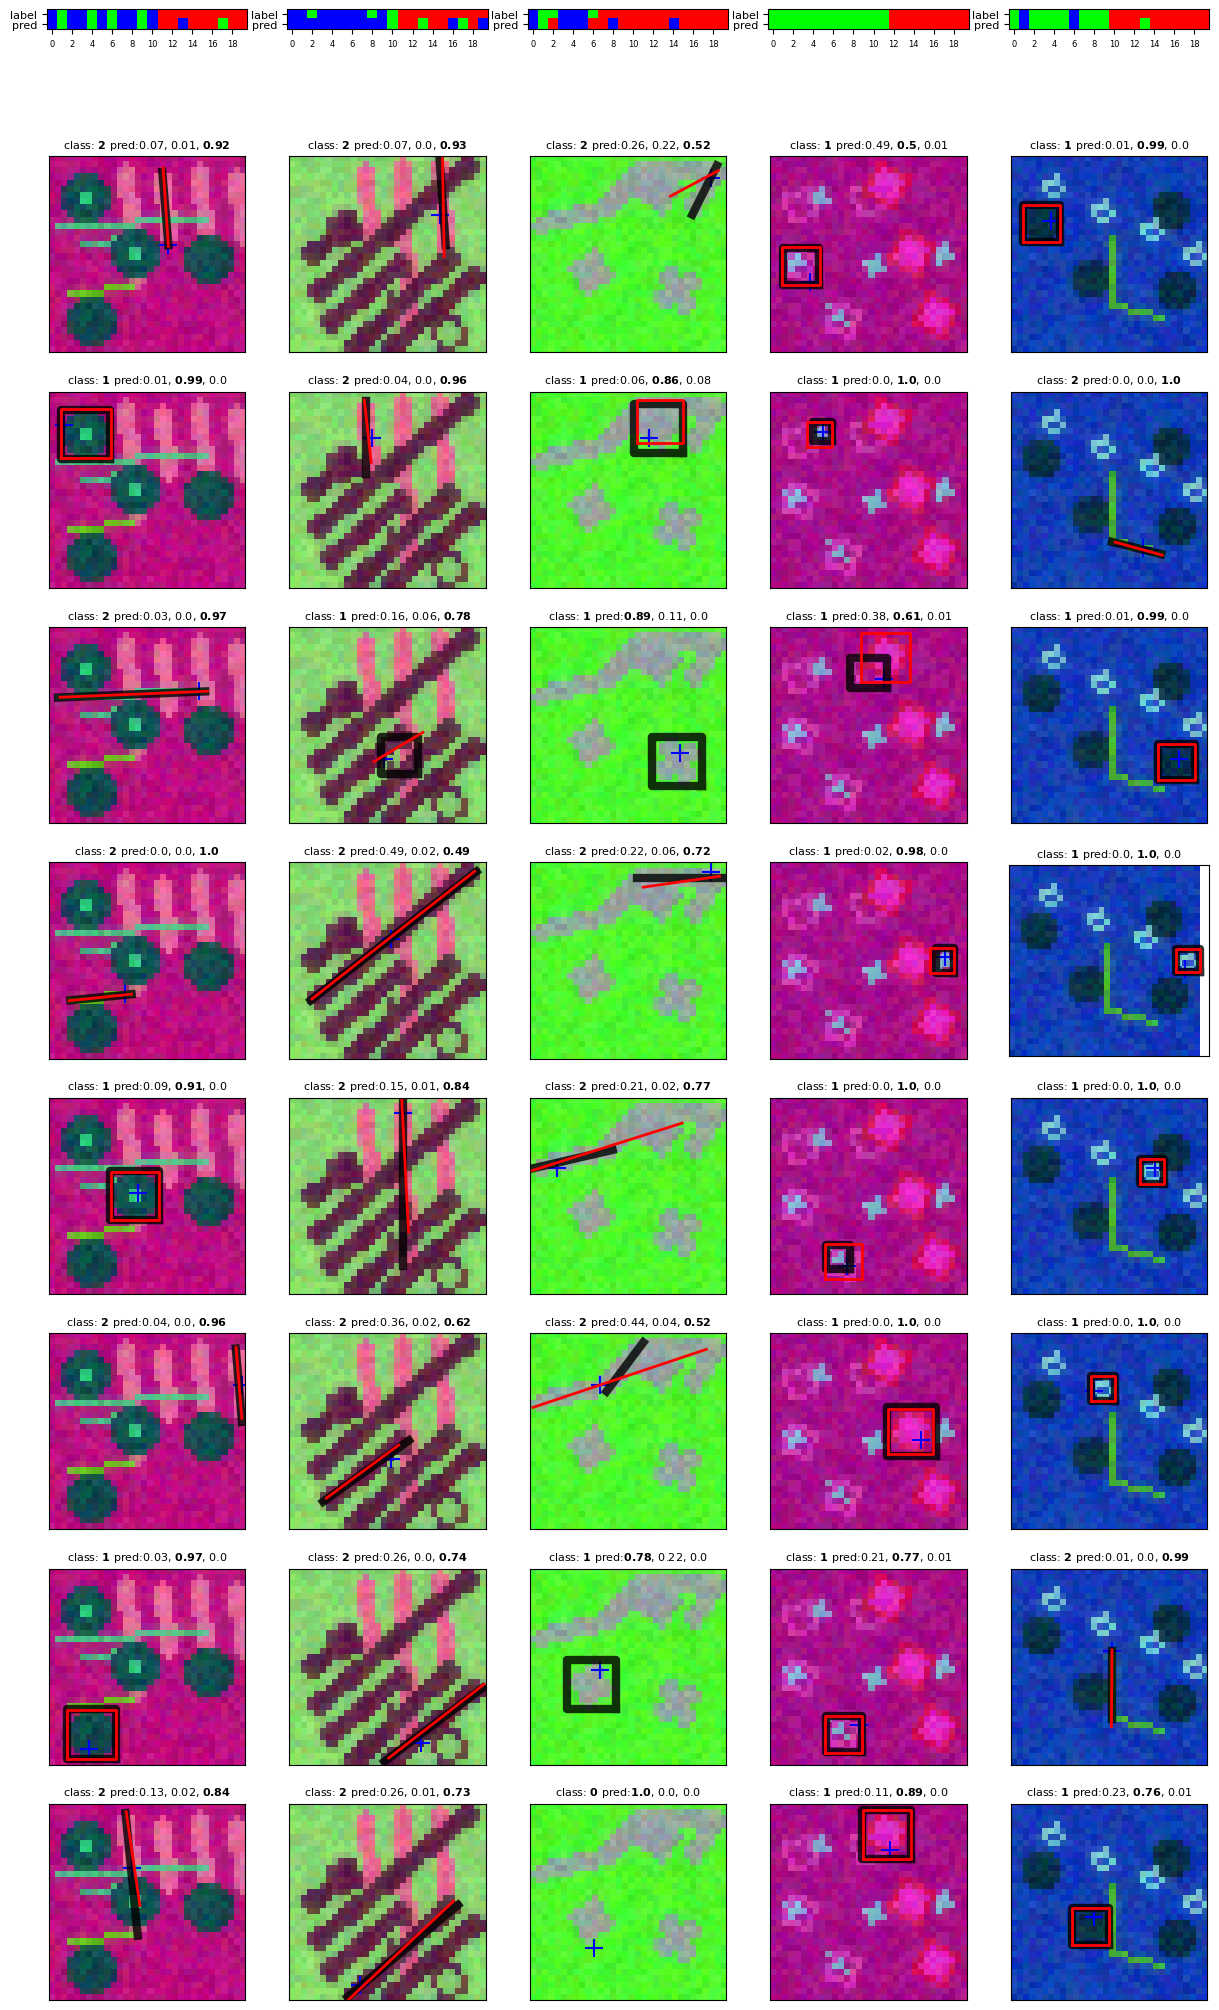

<Figure size 640x480 with 0 Axes>

In [9]:
# Plot results
%run -i ../exp_lib/plots/vec_detection.py --s=5 --r=8

In [8]:
tf.config.experimental.get_memory_info('GPU:0')['peak']*1e-6

805.6709119999999

# Mid Layers Analysis

## MHA scores map

In [43]:
inter_model = tf.keras.Model(trainer.model.input, (trainer.model.get_layer('vdMHA_2').output[1], trainer.model.output))

/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'img' mapping to value <KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=None, name=keras_tensor_571> which has name 'keras_tensor_571'. Change the tensor name to 'img' (via `Input(..., name='img')`)
  warnings.warn(


img (8, 32, 32, 3) <dtype: 'float32'>
sample_points (8, 20, 2) <dtype: 'int32'>
class_split (8, 20) <dtype: 'float32'>
vec_labels (8, 20, 4, 2) <dtype: 'float32'>
components_class (8, 20) <dtype: 'float32'>
vecs_weights (8, 20) <dtype: 'float32'>
class_weights (8, 20) <dtype: 'float32'>
pred_vecs (8, 20, 4, 2) <dtype: 'float32'>
pred_class (8, 20) <dtype: 'float32'>
scores_map (8, 20, 32, 32) <dtype: 'float32'>


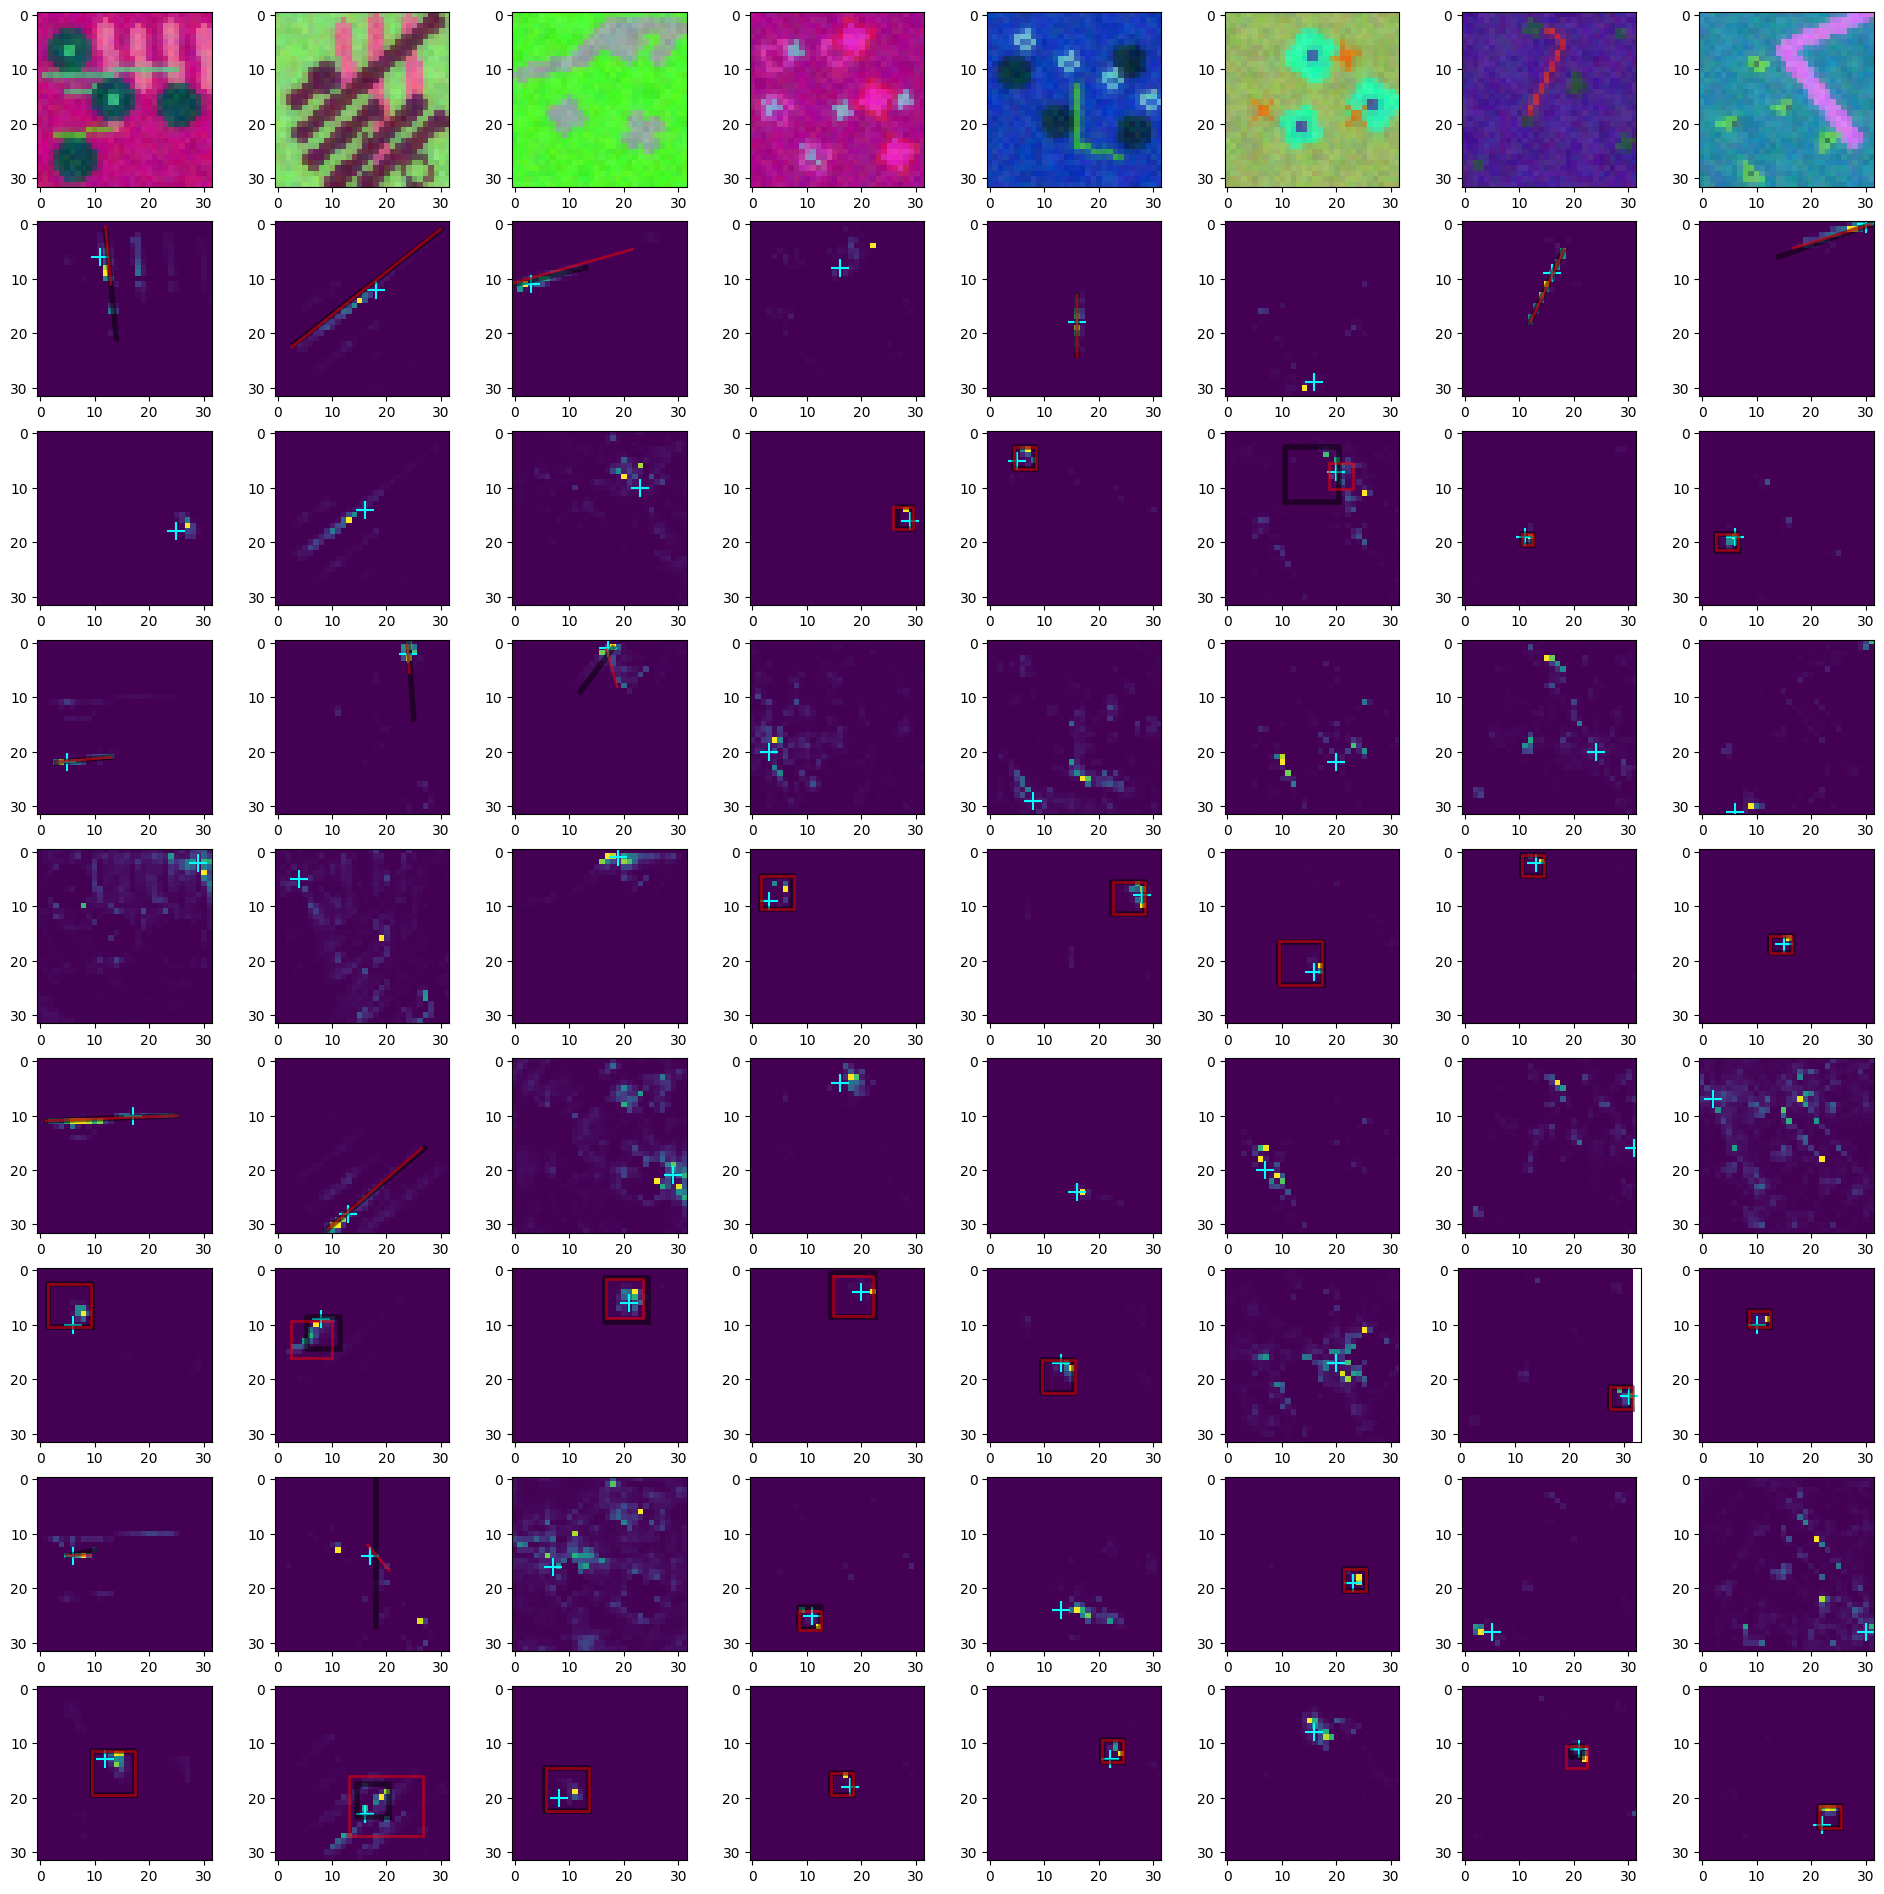

In [44]:
#features, labels, labels_weights = next(test_iter)
img, sample_points, class_split = features.values()
vecs_labels, components_class = labels.values()
vecs_weights, class_weights = [tf.where(o>0, 1.0, 0.0) for o in labels_weights.values()]


print('img', img.shape, img.dtype)
print('sample_points', sample_points.shape, sample_points.dtype)
print('class_split', class_split.shape, class_split.dtype)
print('vec_labels', vecs_labels.shape, vecs_labels.dtype)
print('components_class', components_class.shape, components_class.dtype)
print('vecs_weights', vecs_weights.shape, vecs_weights.dtype)
print('class_weights', class_weights.shape, class_weights.dtype)

vecs_labels =tf.reduce_sum(tf.reshape(vecs_labels, (-1,cfg.sample_points,2,2,2)), axis=-3)



scores_map, preds  = inter_model(features, training=False)
scores_map = tf.reshape(scores_map[:,:,0], (cfg.test_batch_size, cfg.sample_points, generator_cfg.size, generator_cfg.size))
pred_vecs, pred_class = preds.values()

print('pred_vecs', pred_vecs.shape, pred_vecs.dtype)
print('pred_class', pred_class.shape, pred_class.dtype)
print('scores_map', scores_map.shape, scores_map.dtype)
pred_vecs =tf.reduce_sum(tf.reshape(pred_vecs, (-1,cfg.sample_points,2,2,2)), axis=-3)

s=8
i=0

max_rows=8
rows = min(max_rows, cfg.sample_points)

fig, axs = plt.subplots(rows+1, s, figsize=(s*3, rows*3))

for i in range(s):
    i_vecs, i_bboxes = vcm.prepare_components_vecs_to_plot(vecs_labels[i], components_class[i])
    p_vecs, p_bboxes = vcm.prepare_components_vecs_to_plot(pred_vecs[i], components_class[i])

    i_components = [i_vecs[...,j] for j in range(i_vecs.shape[-1])] + [i_bboxes[...,j] for j in range(i_bboxes.shape[-1])]
    p_components = [p_vecs[...,j] for j in range(p_vecs.shape[-1])] + [p_bboxes[...,j] for j in range(p_bboxes.shape[-1])]

    i_sample_points = tf.concat([tf.gather(sample_points[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(sample_points[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    
    i_maps = tf.concat([tf.gather(scores_map[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(scores_map[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    
    i_weights = tf.concat([tf.gather(class_weights[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(class_weights[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    axs[0,i].imshow(img[i])
    for r in range(rows): #range(cfg.sample_points):
        ax = axs[r+1,i]
        r = r if r%2==0 else r//2+cfg.sample_points//2
        ax.imshow(i_maps[r])
        ax.scatter(*i_sample_points[r][::-1], marker='+', color='aqua', s=150)
        if i_weights[r]>0:
            ax.plot(*i_components[r], color='black', linewidth=4, alpha=0.5)
            ax.plot(*p_components[r], color='red', linewidth=2, alpha=0.5)

## Query-Samples

In [36]:
inter_model = tf.keras.Model(trainer.model.input, (trainer.model.get_layer('Query-Sample_2').output, trainer.model.output))

img (8, 32, 32, 3) <dtype: 'float32'>
sample_points (8, 20, 2) <dtype: 'int32'>
class_split (8, 20) <dtype: 'float32'>
vec_labels (8, 20, 4, 2) <dtype: 'float32'>
components_class (8, 20) <dtype: 'float32'>
vecs_weights (8, 20) <dtype: 'float32'>
class_weights (8, 20) <dtype: 'float32'>
pred_vecs (8, 20, 4, 2) <dtype: 'float32'>
pred_class (8, 20) <dtype: 'float32'>
queries_points (8, 20, 8, 2) <dtype: 'float32'>


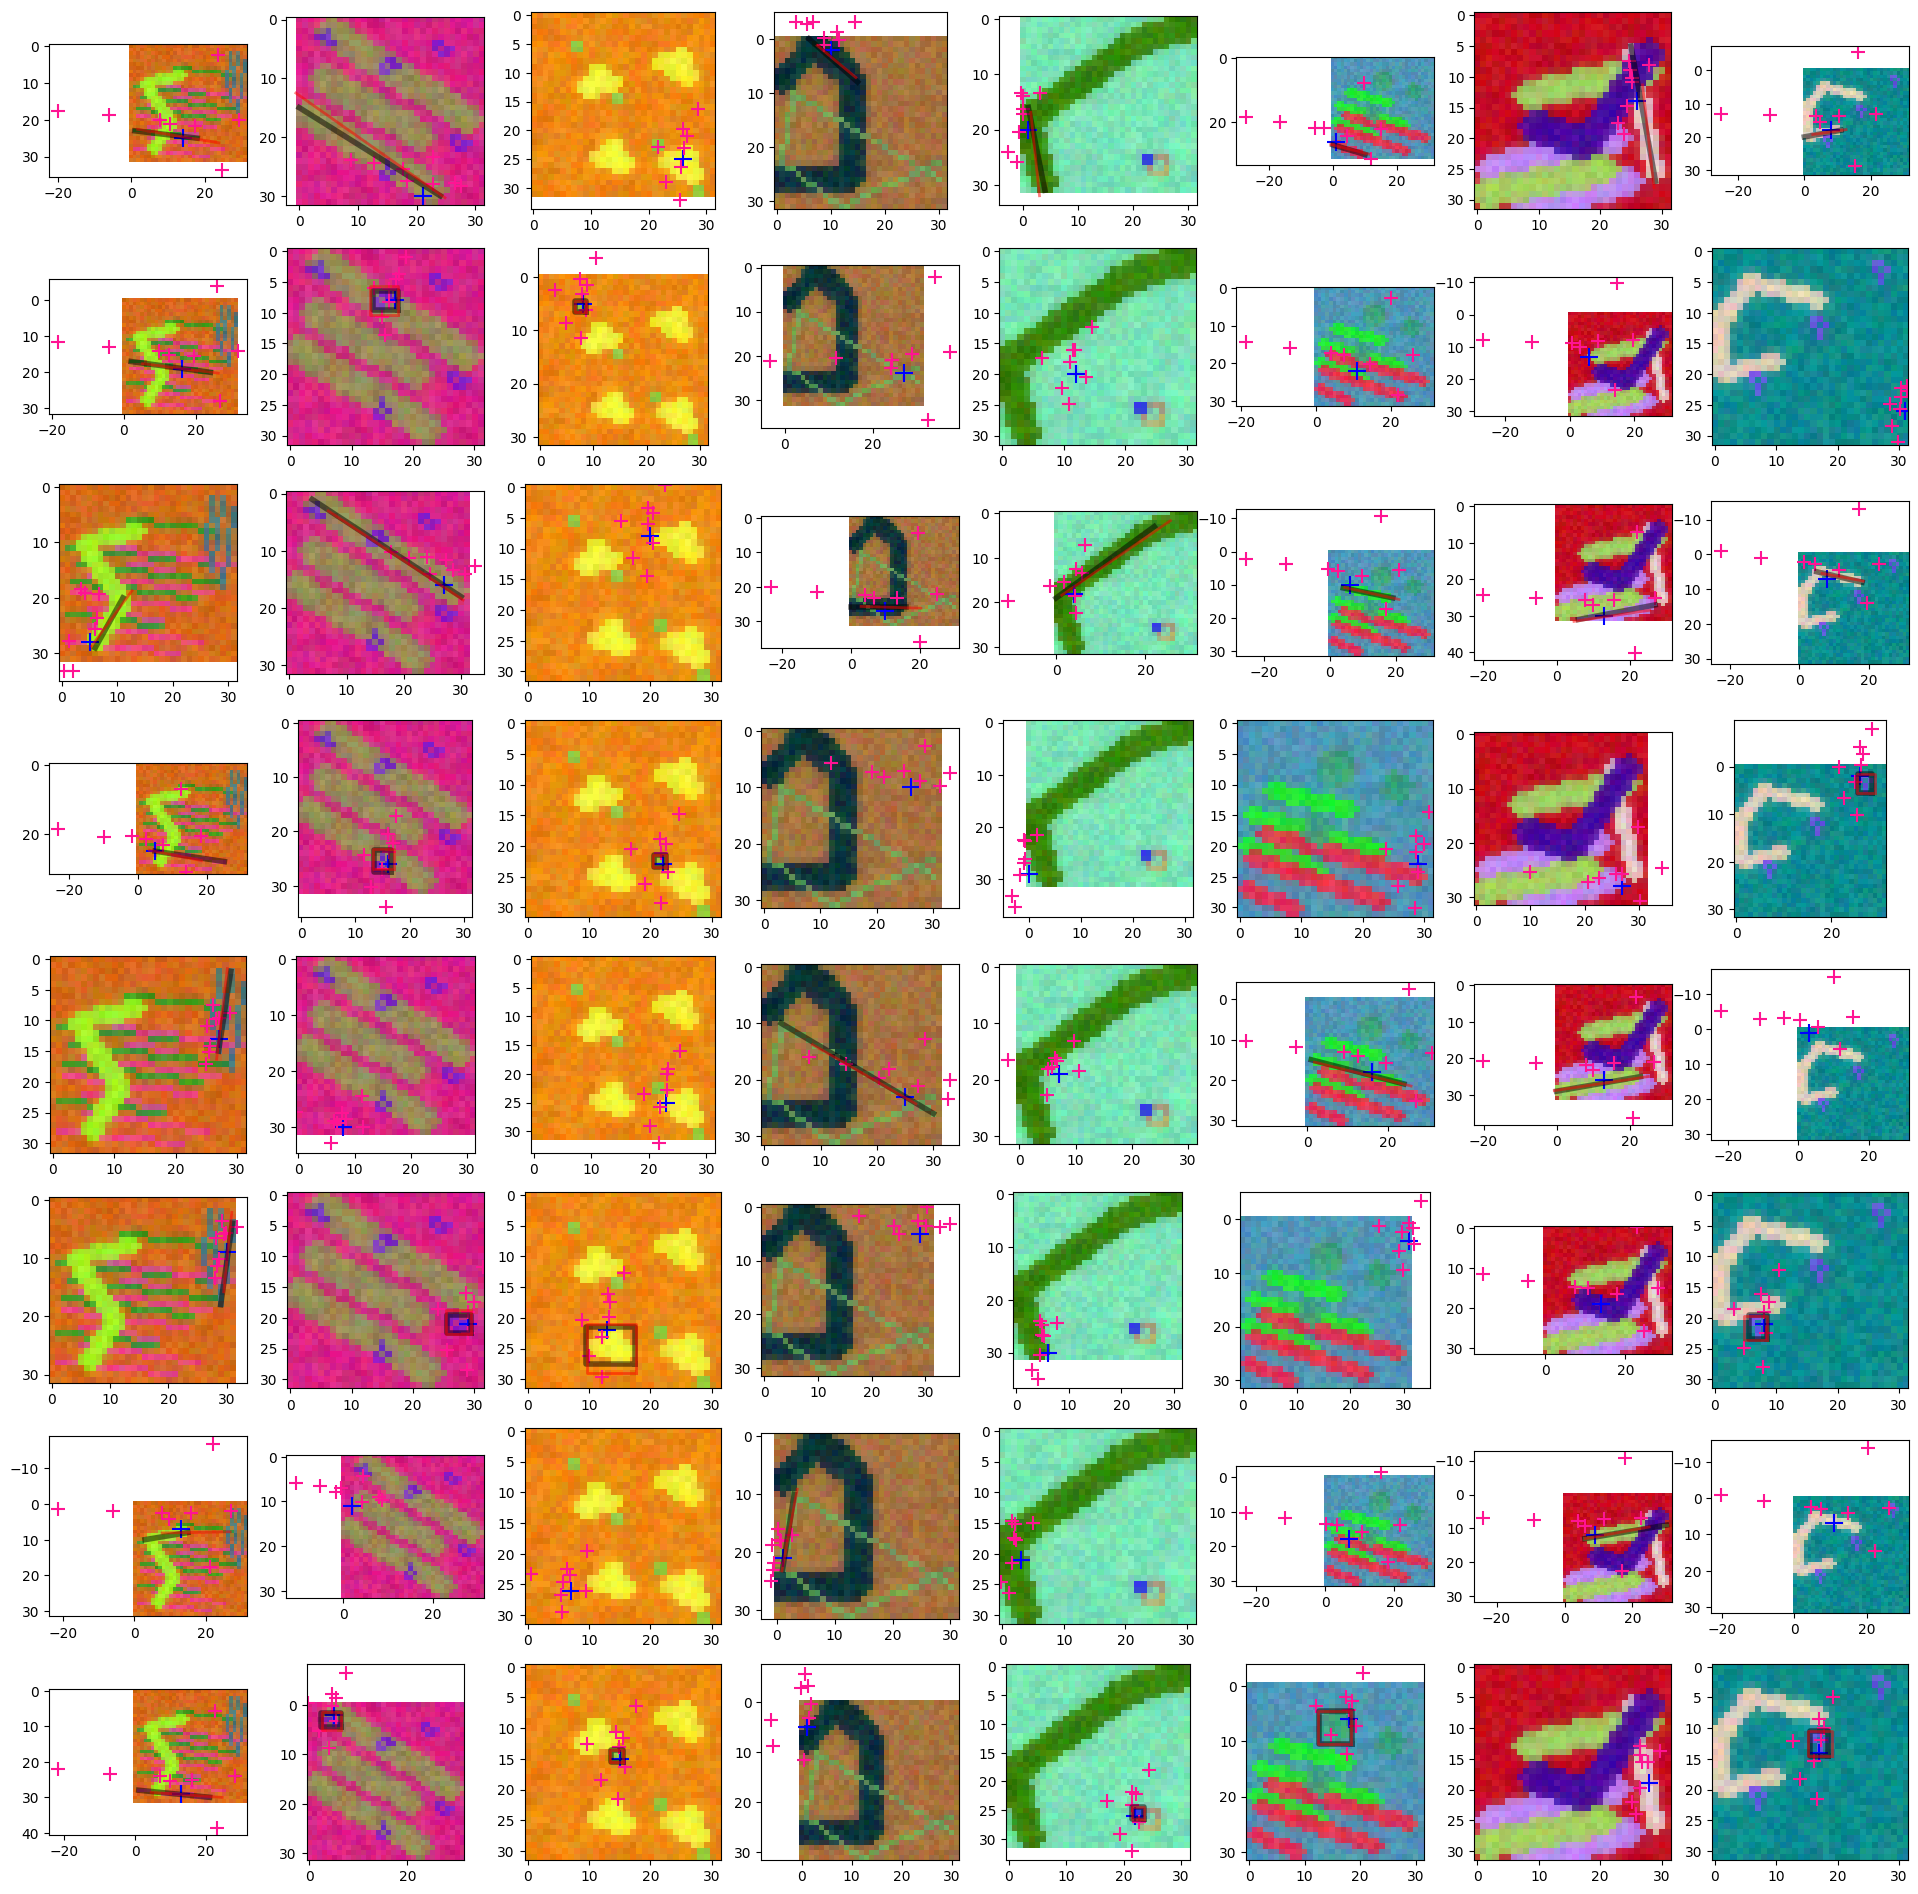

In [37]:
features, labels, labels_weights = next(test_iter)
img, sample_points, class_split = features.values()
vecs_labels, components_class = labels.values()
vecs_weights, class_weights = [tf.where(o>0, 1.0, 0.0) for o in labels_weights.values()]


print('img', img.shape, img.dtype)
print('sample_points', sample_points.shape, sample_points.dtype)
print('class_split', class_split.shape, class_split.dtype)
print('vec_labels', vecs_labels.shape, vecs_labels.dtype)
print('components_class', components_class.shape, components_class.dtype)
print('vecs_weights', vecs_weights.shape, vecs_weights.dtype)
print('class_weights', class_weights.shape, class_weights.dtype)

vecs_labels =tf.reduce_sum(tf.reshape(vecs_labels, (-1,cfg.sample_points,2,2,2)), axis=-3)



queries_points, preds  = inter_model(features, training=False)
pred_vecs, pred_class = preds.values()

print('pred_vecs', pred_vecs.shape, pred_vecs.dtype)
print('pred_class', pred_class.shape, pred_class.dtype)
print('queries_points', queries_points.shape, queries_points.dtype)
pred_vecs =tf.reduce_sum(tf.reshape(pred_vecs, (-1,cfg.sample_points,2,2,2)), axis=-3)

s=8
i=0

max_rows=8
rows = min(max_rows, cfg.sample_points)

fig, axs = plt.subplots(rows, s, figsize=(s*3, rows*3))

for i in range(s):
    i_vecs, i_bboxes = vcm.prepare_components_vecs_to_plot(vecs_labels[i], components_class[i])
    p_vecs, p_bboxes = vcm.prepare_components_vecs_to_plot(pred_vecs[i], components_class[i])

    i_components = [i_vecs[...,j] for j in range(i_vecs.shape[-1])] + [i_bboxes[...,j] for j in range(i_bboxes.shape[-1])]
    p_components = [p_vecs[...,j] for j in range(p_vecs.shape[-1])] + [p_bboxes[...,j] for j in range(p_bboxes.shape[-1])]

    i_sample_points = tf.concat([tf.gather(sample_points[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(sample_points[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    
    i_queries_points = tf.concat([tf.gather(queries_points[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(queries_points[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    
    i_weights = tf.concat([tf.gather(class_weights[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(class_weights[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    for r in range(rows): #range(cfg.sample_points):
        ax = axs[r,i]
        r = r if r%2==0 else r//2+cfg.sample_points//2
        ax.imshow(img[i])
        ax.scatter(*i_sample_points[r][::-1], marker='+', color='blue', s=150)
        ax.scatter(*tf.transpose(i_queries_points[r], [1,0])[::-1], marker='+', color='deeppink', s=100)
        if i_weights[r]>0:
            ax.plot(*i_components[r], color='black', linewidth=4, alpha=0.5)
            ax.plot(*p_components[r], color='red', linewidth=2, alpha=0.5)

# experiments

In [13]:
features = tf.ones((8,1,1024,64))
sample_features = tf.ones((8,20,1,64))
sample_points = tf.ones((8,20,2))
pos_enc = tf.ones((8,20,1024,64))

query_points = tf.ones((8,20,6,2))
unsqueezed_features = tf.ones((8,32,32,64))

shape = tf.shape(query_points)
B, sample_points_num, query_points_num = [shape[i] for i in range(3)]
query_boxes = tf.concat([query_points-0.5, query_points+0.5], axis=-1)
print(query_boxes.shape)
box_indices = tf.reshape(tf.repeat(tf.range(B, dtype=tf.int32)[:,tf.newaxis], sample_points_num*query_points_num, axis=-1), (-1,))
print(box_indices.shape)
query_boxes = tf.reshape(query_boxes, (-1,4))
print(query_boxes.shape)

query_samples = tf.image.crop_and_resize(unsqueezed_features, query_boxes, box_indices, crop_size=[1,1])
print(query_samples.shape)
query_samples = tf.reshape(query_samples, (B, sample_points_num, query_points_num, -1))
print(query_samples.shape)

(8, 20, 6, 4)
(960,)
(960, 4)
(960, 1, 1, 64)
(8, 20, 6, 64)


In [ ]:
query_points = vcm.QuerySamplingLayer(queries_num=6, mid_layers=1, mid_units=64, activation='relu', dropout=0.0)([sample_features, sample_points])
print(query_points.shape)

query_samples = vcm.SampleQueryExtractionLayer(crop_size=[1,1])([features, query_points])
print(query_samples.shape)

a = vcm.SampleQueryMessagePassing(num_heads=1, size=32, mid_layers=1, mid_units=64, activation='relu', dropout=0.0, enc_type='frequency')(sample_features, query_samples, sample_points, query_points)
print(a.shape)

(8, 20, 6, 2)
(8, 20, 6, 64)
(8, 20, 1, 64)


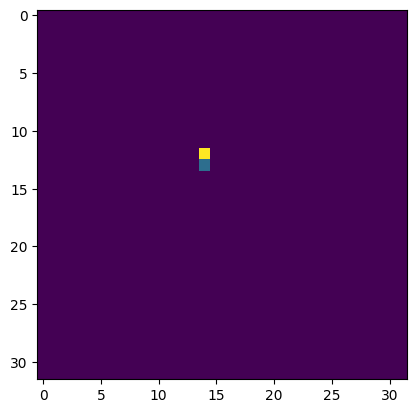

In [ ]:
yx = xy_coords((32,32))[...,::-1]
p = tf.constant([12.4, 14.1], tf.float32)

diffs = tf.reduce_sum(tf.abs(p-yx), axis=-1, keepdims=True)
bilinear_map = tf.nn.relu(1-diffs+1e-4)**2
bilinear_map /= tf.reduce_sum(bilinear_map)+1e-4
plt.imshow(bilinear_map)